# 4 Capstone II Preprocessing and Training

## Introduction

Create and assess models.

Validate

# 4.1 Imports

In [1]:
import os
from library.sb_utils import save_file

import pandas as pd
import numpy as np

import datetime
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import __version__ as sklearn_version

from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.pipeline import make_pipeline

# 4.2 Load The Data

## 4.2.1 Profiles Data

In [2]:
# Load the data
full_data = pd.read_csv('../data/data_step3_features.csv')

In [3]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971 entries, 0 to 970
Data columns (total 47 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RFY-PAD-District    971 non-null    object 
 1   RFY_ID              971 non-null    object 
 2   RFY_BPCD            971 non-null    int64  
 3   CATHYDTRMT          971 non-null    int64  
 4   COKING              971 non-null    int64  
 5   Crude_API           971 non-null    float64
 6   GSL_Yield_PAD       971 non-null    float64
 7   DSL_Yield_PAD       971 non-null    float64
 8   RESID_Yield_PAD     971 non-null    float64
 9   WTI_Acq_Cost        971 non-null    float64
 10  SPECF_CRCK_PAD-1A   971 non-null    float64
 11  SPECF_CRCK_PAD-1B   971 non-null    float64
 12  SPECF_CRCK_PAD-1C   971 non-null    float64
 13  SPECF_CRCK_PAD-2    971 non-null    float64
 14  SPECF_CRCK_PAD-3    971 non-null    float64
 15  SPECF_CRCK_PAD-4    971 non-null    float64
 16  SPECF_CR

In [4]:
data = full_data.iloc[:, np.r_[0:10, 25:33, 17]]

In [5]:
# Get the row indecies of the fictional observations with the 'RFY-PAD-District' variable labeled 'FALCON':
data[data['RFY-PAD-District'] == 'FALCON'].T

,726,848,970
RFY-PAD-District,FALCON,FALCON,FALCON
RFY_ID,RFY-201,RFY-202,RFY-203
RFY_BPCD,50000,50000,50000
CATHYDTRMT,379700,379700,379700
COKING,1358935,1358935,1358935
Crude_API,27.97,29.1133,26.1155
GSL_Yield_PAD,41.75,41.75,41.75
DSL_Yield_PAD,50.88,50.88,50.88
RESID_Yield_PAD,6.77,6.77,6.77
WTI_Acq_Cost,49.9992,50.9408,32.47


## 4.2.2 Prepare source data for training/test split

In [6]:
# Separate the fictional observations into its own dataframe
falcon_data = data[data['RFY-PAD-District'] == 'FALCON']

In [7]:
# Separate the actual observations into another dataframe
rfy_data = data.iloc[np.r_[0:726, 727:848, 849:970], :]

In [8]:
# Check that no fictional observations are left in the actual observations data set
rfy_data[rfy_data['RFY-PAD-District'] == 'FALCON']

,RFY-PAD-District,RFY_ID,RFY_BPCD,CATHYDTRMT,COKING,Crude_API,GSL_Yield_PAD,DSL_Yield_PAD,RESID_Yield_PAD,WTI_Acq_Cost,WTI_Price,BPD_DENS_PAD-1A,BPD_DENS_PAD-1B,BPD_DENS_PAD-1C,BPD_DENS_PAD-2,BPD_DENS_PAD-3,BPD_DENS_PAD-4,BPD_DENS_PAD-5,SPECF_RFY_CRCK


# 4.3 Split Data into Train/Test partitions

## 4.3.1 Split 70/30

In [9]:
# estimate partition sizes
round(len(rfy_data)*.7), round(len(rfy_data)*.3)

(678, 290)

In [10]:
# Train/Test split
# remove object variables, keep only numerical
X_train, X_test, y_train, y_test = train_test_split(rfy_data.drop(columns=['SPECF_RFY_CRCK', 'RFY-PAD-District', 'RFY_ID']),
                                                   rfy_data['SPECF_RFY_CRCK'], test_size=0.3, random_state=47)

In [11]:
X_train.shape, X_test.shape

((677, 16), (291, 16))

In [12]:
y_train.shape, y_test.shape

((677,), (291,))

## 4.3.2 Metrics

### 4.3.2.1 Dummy Regressor

In [13]:
# calculate the mean of 'y_train'
train_mean = y_train.mean()
train_mean

26.517888727509114

In [14]:
# Fit dummy regressor on training data
d_reg = DummyRegressor(strategy='mean')
d_reg.fit(X_train, y_train)
d_reg.constant_

array([[26.51788873]])

### 4.3.2.2 sklearn Metrics

In [15]:
# Use dummy regressor to create an array of the training set length, populated with its mean value
y_tr_pred = d_reg.predict(X_train)
y_tr_pred[:5]

array([26.51788873, 26.51788873, 26.51788873, 26.51788873, 26.51788873])

In [16]:
# create an array of the test set length, but populated with the training set mean value:
y_test_pred = train_mean * np.ones(len(y_test))
y_test_pred[:5]

array([26.51788873, 26.51788873, 26.51788873, 26.51788873, 26.51788873])

#### Calculate the R-squared score on the training set:

In [17]:
r2_score(y_train, y_tr_pred)

0.0

#### Calculate the R-squared score on the test set:

In [18]:
r2_score(y_test, y_test_pred)

-0.020215225635826783

As expected, the performance of R-squared score on a test set is worse than on the training set.

#### Mean Absolute Error (MAE) - on the training and the test sets:

In [19]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_test_pred)

(20.206460112349756, 19.15869968558811)

# 4.4. Models

#### Make initial predictions:
* scale the features
* train a model
* assess model performance

## 4.4.1 Initial predictions

### 4.4.1.1 Scale the features

In [20]:
# Fit the scaler on the training data
# Use 'transofrm()' method to apply the scaling on the train and test split
scaler = StandardScaler()
scaler.fit(X_train)

X_tr_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### 3.4.1.2 Verify Scaling

Verify and compare scaling for the training and test sets - mean (is close to zero?), standard deviation (is close to 1?)

In [21]:
X_tr_scaled.mean(), X_tr_scaled.std()

(-2.6041863561369996e-16, 1.0)

In [22]:
X_test_scaled.mean(), X_test_scaled.std()

(-0.03676118313330023, 0.9835082490690708)

### 4.4.1.2 Train the model on the train split

In [23]:
lm = LinearRegression().fit(X_tr_scaled, y_train)

### 4.4.1.3 Make prediciotns using the model on the train and test splits:

In [24]:
# Call the 'predict()' method of the 'lm' model on the scaled train and test splits:
y_tr_pred = lm.predict(X_tr_scaled)
y_test_pred = lm.predict(X_test_scaled)

### 4.4.1.4 Assess model performance:

#### R-squared scores:

In [25]:
# R-squared scores on the training and test data:
median_r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_test_pred)
median_r2

(0.9351107276013582, 0.9193748345604587)

It looks like the 'lm' linear regresion model explains 92%+ of the variance on both the training and test data sets.

#### Mean Absolute Error scores:

In [26]:
# Mean absolue error scores on the train and test splits:
median_mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_test_pred)
median_mae

(5.517589743284357, 5.780487409579969)

This model is expected to estimate the aggregate crack srpread for a given refinery within $5.5/Bbl of the real crack spread value.

#### Mean Squared Error scores:

In [27]:
# Mean squared error scores on the train and test splits:
median_mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_test_pred)
median_mse

(35.40714802994405, 38.6415385651366)

In [28]:
# a square root of the mse, for the root mean square error:
# np.sqrt([mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_test_pred)])
np.sqrt(median_mse)

array([5.95039058, 6.21623186])

#### Next, create a pipline, a single object for feature scaling and regression process steps

## 4.4.2 Pipelines

#### We will create a pipline that will define the same steps as above:
- Scale the data to zero mean and unit variance
- train a linear regression model
- assess the model performance

### 4.4.2.1 Define the pipeline:

In [29]:
pipe = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

### 4.4.2.2 Fit the pipeline:

In [30]:
# Scaling: determine the mean to substract to get to zero, determine the variance to divide by to get to 1
# Train the model
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

### 4.4.2.3 Make predictions on the train and test sets

In [31]:
y_tr_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

### 4.4.2.4 Assess performance

In [32]:
# R-squared scores on the training and test data - compare with previous 'non-pipeline' results:
'pipeline results: ', r2_score(y_train, y_tr_pred), r2_score(y_test, y_test_pred), 'non-pipline results: ', median_r2

('pipeline results: ',
 0.9351107276013582,
 0.9193748345604587,
 'non-pipline results: ',
 (0.9351107276013582, 0.9193748345604587))

In [33]:
# Mean absolue error scores on the train and test splits - compare with previous 'non-pipeline' results::
'pipeline results: ', mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_test_pred), 'non-pipeline results: ', median_mae

('pipeline results: ',
 5.517589743284357,
 5.780487409579969,
 'non-pipeline results: ',
 (5.517589743284357, 5.780487409579969))

In [34]:
# Mean squared error scores on the train and test splits - compare with previous 'non-pipeline' results:
'pipeline results: ', mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_test_pred), 'non-pipeline results: ', median_mse


('pipeline results: ',
 35.40714802994405,
 38.6415385651366,
 'non-pipeline results: ',
 (35.40714802994405, 38.6415385651366))

Pipeline results match with the earlier assessments

# 4.5 Refine the model

## 4.5.1 Re-define the pipeline

### 4.5.1.1 Add a Feature selection function:

Add a sklearn's SelectKBest feature selection function

In [35]:
# Use the SelectKBest's default k=10
pipe = make_pipeline(
    StandardScaler(),
    SelectKBest(f_regression, k=10),
    LinearRegression()
)

### 4.5.1.2 Fit the pipeline

In [36]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x00000200875BEF70>)),
                ('linearregression', LinearRegression())])

### 4.5.1.3 Assess performance on the train and test sets

In [37]:
y_tr_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [38]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_test_pred)

(0.9329836276445814, 0.9184539571648571)

In [39]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_test_pred)

(5.739754420746994, 5.941504950465883)

Since the assessment results look worse than before addin the feature selection function (set at default k=10), we will try k=15

### 4.5.1.4 Pipeline with a higher value k=15

In [40]:
# Use k=15 for the SelectKBest
pipe15 = make_pipeline(
    StandardScaler(),
    SelectKBest(f_regression, k=15),
    LinearRegression()
)

### 4.5.1.5 Fit the pipeline

In [41]:
pipe15.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=15,
                             score_func=<function f_regression at 0x00000200875BEF70>)),
                ('linearregression', LinearRegression())])

### 4.5.1.6 Assess performance on the train and test sets

In [42]:
y_tr_pred = pipe15.predict(X_train)
y_test_pred = pipe15.predict(X_test)

In [43]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_test_pred)

(0.9350759698676994, 0.9197023961070783)

In [44]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_test_pred)

(5.517113308129045, 5.771430474925699)

#### The performance has improved; however, we need the model to generalize to new data. We will use the cross-validation next.

## 4.5.2 Performance Assessment with Cross-Validation

#### Use the previous pipeline steps and cross-validation folds cv=5

In [45]:
cv_results = cross_validate(pipe15, X_train, y_train, cv=5)

In [46]:
cv_scores = cv_results['test_score']
cv_scores

array([0.90955205, 0.92966815, 0.93269343, 0.93960364, 0.93550725])

In [47]:
np.mean(cv_scores), np.std(cv_scores)

(0.9294049039155394, 0.010452488194783605)

In [48]:
np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)

array([0.91, 0.95])

## 4.5.3 Hyperparameter search using GridSearchCV

We will now run the pipeline and cross-validation technique for multiple values of k to pick the best performance.

In [49]:
# Get the dictionary of available parameters:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'selectkbest', 'linearregression', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize'])

##### Caluclate the range of k to investigate:

In [50]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

##### Deterine the best value k:

In [51]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [52]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x00000200875BEF70>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16]})

In [53]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [54]:
lr_grid_cv.best_params_

{'selectkbest__k': 13}

##### Assign the best value of k determined above to 'best_k' - plot the CV score against values of k:

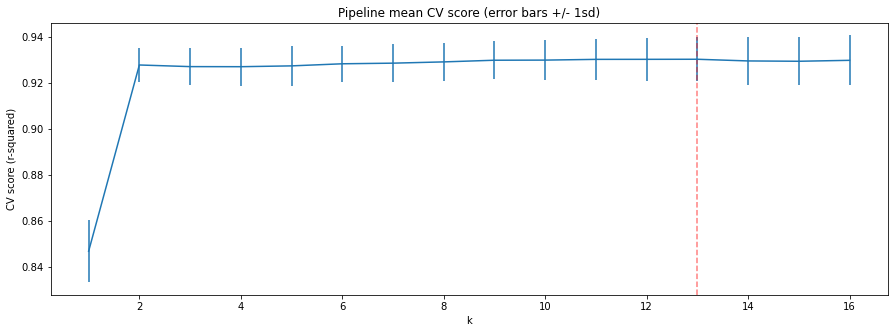

In [55]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(15, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

The hyperparameter search has determined that the best value for k is 16. Let's look at which features were most useful.

In [56]:
# logical mask of the selected features
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
selected

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True])

##### Access the named step of the model and its coefficients:

In [57]:
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

WTI_Price          47.610678
CATHYDTRMT          3.264044
RFY_BPCD            1.655841
RESID_Yield_PAD     0.683886
BPD_DENS_PAD-1B     0.658622
BPD_DENS_PAD-5     -0.034730
BPD_DENS_PAD-1C    -0.340273
BPD_DENS_PAD-2     -0.641927
DSL_Yield_PAD      -0.856367
BPD_DENS_PAD-3     -1.016557
GSL_Yield_PAD      -1.038688
COKING             -2.898170
WTI_Acq_Cost      -27.276185
dtype: float64

# 4.6 Random Forest Model

## 4.6.1 Define the pipeline for Random Forest

In [58]:
# Define a new pipeline for the  Random Forest model
RF_pipe = make_pipeline(
    #SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

## 4.6.2 Fit and assess performance using cross-validation

In [59]:
# Call 'cross-validate' to assess the pipeline's performance
# pass the random forest pipe object, 'X_train' and 'y_train' to the 'cross-validate method', using 5-fold cv
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [60]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.99948472, 0.99963841, 0.99935992, 0.99934953, 0.99916978])

In [61]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.9994004720196032, 0.00015567322948593083)

## 4.6.3 Hyperparameter search using GridSearchCV

### 4.6.3.1 Run without feature scaling:

In [62]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None]
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None]}

In [63]:
# Call 'GridSearchCV' with the random forest pipeline, 'grid_params' dict, cv=5
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [64]:
# Start the grid search:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'standardscaler': [StandardScaler(), None]})

In [65]:
# print the best params from the above grid search
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 88, 'standardscaler': StandardScaler()}

In [66]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.99946616, 0.99964373, 0.99935592, 0.999383  , 0.99918956])

In [67]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.9994076726731066, 0.0001483282500835948)

Not much of a difference

##### Assign the 'feature_importances' attribue to 'imps' - plot the Importance against the feature column names:

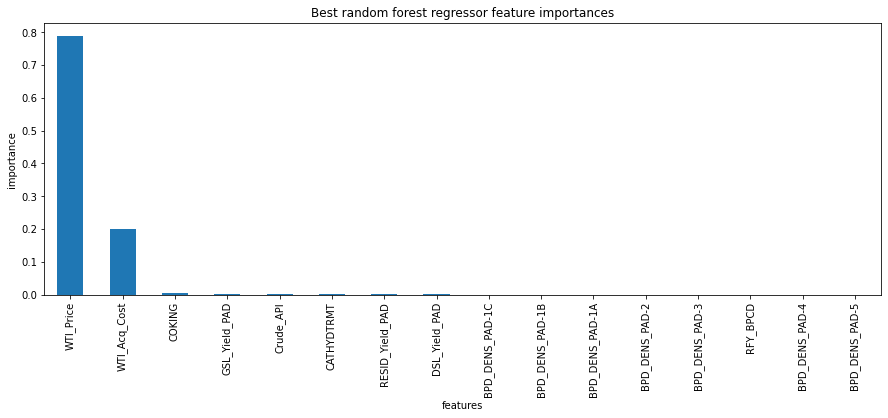

In [68]:
plt.subplots(figsize=(15, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

The Random Forest returned a much more sensible ranking of the importance features than the linear model:
* WTI_Price - crude oil price market index 
* WTI_Acq_Cost - actual crude oil price paid by refineries
* Coking - whether a refinery had 'Cocking' capacity
* GSL_Yield_PAD - how much gasoline a given refinery could produce per each barrel of crude processed
* Crude_API - quality of crude

## 4.7 Model Selection

## 4.7.1 Linear regression model performance

In [69]:
# 'neg_mean_absolute_error' uses the (negative of) the mean absolute error
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [70]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(5.725972243648259, 0.19735737873677345)

In [71]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

5.939653812870975

## 4.7.2 Random forest regression model performance

In [72]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [73]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(0.2520526035762372, 0.04629445062045106)

In [74]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

0.17025579357090267

## 4.7.3 Conculsion

Clearly, the random forest model shows a lot less variability and much lower cross-validation mean absolute error.

## 4.8 Data quality assessment

Assess how much performance varies with differing data set sizes:

In [75]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

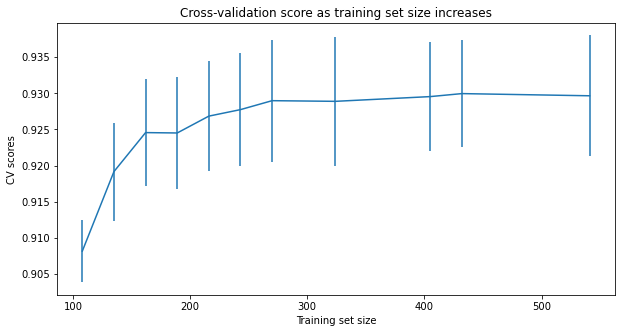

In [76]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

The plot shows that the improvement of the model score performance starts flattening at around 250 sample size

## 4.9 Save the best model object from pipeline

In [77]:
# Get the basic information about the best model
best_model = rf_grid_cv.best_estimator_
best_model.version = ___
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [78]:
# Save the model
modelpath = '../models'
save_file(best_model, 'refinery_crackspread_model.pkl', modelpath)

Directory ../models was created.
Writing file.  "../models\refinery_crackspread_model.pkl"
